In [ ]:
# Skeleton code from:
# Introduction to Neural Networks (CSE 40868/60868)
# University of Notre Dame
# Practical 2: Convolutional Neural Networks and Transfer Learning
# _________________________________________________________________________
# Yifan Qin, Zheng Ning, Adam Czajka, February 2023

### Step 1: Load Pytorch and other packages, which we will use today

In [1]:
%pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import resize
from torchvision.transforms import CenterCrop
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.io import read_image
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import pandas as pd
import librosa
from IPython.display import Audio
import imageio.v2 as imageio
from skimage.color import rgba2rgb, rgb2gray
import matplotlib.pyplot as plt
import csv
import argparse
from torch.utils.data.dataloader import default_collate
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix



### Step 2: Mount your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mp3_path = 'drive/MyDrive/NeuralNetworksProject/data/train'
mp3_files = os.listdir(mp3_path)
png_path = 'drive/MyDrive/NeuralNetworksProject/spec_copy/train'
png_files = os.listdir(png_path)


# create song to label mapping
genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
# build library mapping from song to genre
song_to_genre_show = {}
with open(f"drive/MyDrive/NeuralNetworksProject/output.csv", newline='') as csvfile:
  spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
  for row in spamreader:
    song_to_genre_show[int(row[0])] = genres.index(row[1])

### Choose Audio File To diplay ###

In [ ]:
SONG_NUMBER = 1337
# SONG_NUMBER = 1390 ## pop example
# SONG_NUMBER = 1337 ## experimental example
# SONG_NUMBER = 1425 ## folk example 
# SONG_NUMBER = 1335 ## Hip-Hop example
spec_file = png_path + '/' + png_files[SONG_NUMBER]
audio_file = mp3_path + '/' + png_files[SONG_NUMBER][:-4] + ".mp3"

### Display Input and lable ###

Genre:
Experimental


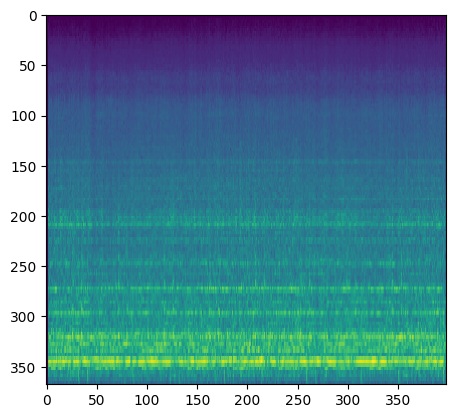

In [ ]:
print("Genre:")
print(genres[song_to_genre_show[int(png_files[SONG_NUMBER][:-4])]])
# Load a PNG file
image = imageio.imread(spec_file)
# Convert the RGBA image to RGB using 
rgb_image = rgba2rgb(image)
# Convert the RGB image to grayscale 
gray_image = rgb2gray(rgb_image)
# take just the graph part of the image
plt.imshow(np.array(gray_image)[59: 427, 79:477])

### Play Audio ##

In [ ]:
Audio(audio_file, autoplay=False)

### Data Loaders ###

In [4]:

class TrainData(torch.utils.data.Dataset):
    def __init__(self,args):
        self.args = args
        self.input_sequence , self.output_sequence = self.loadData()

    def loadData(self):
        inputs = []
        outputs = []

        genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
        # build library mapping from song to genre
        song_to_genre = {}
        with open(f"{self.args.workingDir}/{self.args.outputFile}.csv", newline='') as csvfile:
          spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
          for row in spamreader:
            song_to_genre[int(row[0])] = genres.index(row[1])

        folder_path = self.args.workingDir + "/spec_copy/train"
        # idx =0
        for file_name in os.listdir(folder_path):
            # if idx % 100 == 0:
            #   print(idx)
            # idx += 1
            if file_name.endswith('.png'):
                # Load a PNG image  as a NumPy array
                image = imageio.imread(os.path.join(folder_path, file_name))
                # Convert the RGBA image to RGB
                rgb_image = rgba2rgb(image)
                # Convert the RGB image to grayscale 
                gray_image = rgb2gray(rgb_image)
                inputs.append(np.array(gray_image)[59: 427, 79:477])
                cur_genre = song_to_genre[int(file_name[:-4])]
                outputs.append(cur_genre)
            

        return(inputs, outputs)


    def __len__(self):
        # Get the number of sequences for training purpose.
        return len(self.input_sequence)

    
    def __getitem__(self, index):
        return (
            self.input_sequence[index],
            self.output_sequence[index],
        )
        

class ValData(torch.utils.data.Dataset):
    def __init__(self,args):
        self.args = args
        self.input_sequence , self.output_sequence = self.loadData()

    def loadData(self):
        inputs = []
        outputs = []

        genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
        # build library mapping from song to genre
        song_to_genre = {}
        with open(f"{self.args.workingDir}/{self.args.outputFile}.csv", newline='') as csvfile:
          spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
          for row in spamreader:
            song_to_genre[int(row[0])] = genres.index(row[1])

        folder_path = self.args.workingDir + "/spec_copy/val"
        idx =0
        for file_name in os.listdir(folder_path):
            idx += 1
            if file_name.endswith('.png'):
                # Load a PNG image as a NumPy array
                image = imageio.imread(os.path.join(folder_path, file_name))
                # Convert the RGBA image to RGB 
                rgb_image = rgba2rgb(image)
                # Convert the RGB image to grayscale
                gray_image = rgb2gray(rgb_image)
                inputs.append(np.array(gray_image)[59: 427, 79:477])
                cur_genre = song_to_genre[int(file_name[:-4])]
                outputs.append(cur_genre)
            

        return(inputs, outputs)


    def __len__(self):
        return len(self.input_sequence)
       

    
    def __getitem__(self, index):
        return (
            self.input_sequence[index],
            self.output_sequence[index],
        )
        
class TestData(torch.utils.data.Dataset):
    def __init__(self,args):
        self.args = args
        self.input_sequence , self.output_sequence = self.loadData()

    def loadData(self):
        inputs = []
        outputs = []

        genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
        # build library mapping from song to genre
        song_to_genre = {}
        with open(f"{self.args.workingDir}/{self.args.outputFile}.csv", newline='') as csvfile:
          spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
          for row in spamreader:
            song_to_genre[int(row[0])] = genres.index(row[1])

        folder_path = self.args.workingDir + "/spec_copy/test"
        idx =0
        for file_name in os.listdir(folder_path):
            idx += 1
            if file_name.endswith('.png'):
                # Load a PNG image file as a NumPy array
                image = imageio.imread(os.path.join(folder_path, file_name))
                # Convert the RGBA image to RGB 
                rgb_image = rgba2rgb(image)
                # Convert the RGB image to grayscale 
                gray_image = rgb2gray(rgb_image)
                inputs.append(np.array(gray_image)[59: 427, 79:477])
                cur_genre = song_to_genre[int(file_name[:-4])]
                outputs.append(cur_genre)
            

        return(inputs, outputs)


    def __len__(self):
        return len(self.input_sequence)
    
    def __getitem__(self, index):
        return (
            self.input_sequence[index],
            self.output_sequence[index],
        )
        

### Build the CNN class defining our network

In [5]:
class CNN(nn.Module):

    def __init__(self, numChannels, numClasses, dropout_rate):
        super(CNN, self).__init__()
        self.classes = numClasses

        self.conv1 = nn.Conv2d(in_channels = numChannels, out_channels = 64, kernel_size = (4,4), stride = (2,2), padding = 1) # to 32
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 4), stride = (2,2), padding = 1) # to 16
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (4,4), stride = (2,2), padding = 1) # to 8 
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (4,4), stride = (2,2), padding = 1) # to 4
        self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = (4,4), stride = (2,2), padding = 1) # to 2


        # Activation function:
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        # Pooling layer:
        self.maxpool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.avepool = nn.AvgPool2d(kernel_size = (2, 2), stride = (2,2))

        # Batch normalization layers:
        self.batchnorm1 = nn.BatchNorm2d(num_features = 64)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 128)
        self.batchnorm3 = nn.BatchNorm2d(num_features = 256)
        self.batchnorm4 = nn.BatchNorm2d(num_features = 512)
        self.batchnorm5 = nn.BatchNorm2d(num_features = 1024)

        # dropout not used
        self.dropout = nn.Dropout(dropout_rate)
        # Fully-connected layers:
        self.fc1 = nn.Linear(in_features = 6144, out_features= 512)

        # FC3 is actually second layer named incorrectly on accidnet during training so need to keep same name
        self.fc3 = nn.Linear(in_features = 512, out_features= 8)

    # Evaluation function
    def evaluate(self, model, dataloader, classes, device):

        # We need to switch the model into the evaluation mode
        model.eval()
        
        # Prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}

        # For all test data samples:
        for data in dataloader:
            images, labels = data
            images = images.float()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            images = images.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            predictions = predictions.detach().cpu().numpy()

            # Count the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                
                # If you want to see real and predicted labels for all samples:
                # print("Real class: " + classes[label] + ", predicted = " + classes[prediction])
                
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

        # Calculate the overall accuracy on the test set
        acc = sum(correct_pred.values()) / sum(total_pred.values())

        return acc


    def forward(self, x):
        x = x.unsqueeze(dim = 1)

        # convolution layers
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = self.relu(x)


        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.maxpool(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)

 
       
        x = torch.flatten(x, 1)

        #fully connected layers
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc3(x)

        return x


###  Set arguments and hyper parameters ###

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--workingDir', type=str, 
    default="/content/drive/MyDrive/NeuralNetworksProject")
# Can be game_of_thrones or wonder_land:
parser.add_argument('--outputFile', type=str, default="output") 
parser.add_argument('--maxEpochs', type=int, default=1000)
parser.add_argument('--batchSize', type=int, default=32)
parser.add_argument('--learningRate', type=float, default=.0001)
parser.add_argument('--dropoutRate', type=float, default=0.3)
parser.add_argument('--num_channels', type=float, default=1)
args = parser.parse_args()

### Load datasets takes some time ###

In [ ]:
trainset = TrainData(args)
train_loader = DataLoader(trainset,  batch_size=args.batchSize, shuffle=False, drop_last=False, num_workers=0)
valset = ValData(args)
val_loader = DataLoader(valset, batch_size=args.batchSize, shuffle=False, drop_last=False, num_workers=0)
testset = TestData(args)
test_loader = DataLoader(testset, batch_size=args.batchSize, shuffle=False, drop_last=False, num_workers=0)
print(trainset.__len__())
print(valset.__len__())

NameError: ignored

# RUN THIS CELL ONLY IF YOU WANT TO TRAIN THE NETWORK #

In [ ]:
if __name__ == '__main__':

    # Specify the operation mode:
    # 'train' = training with your train and validation data splits
    # 'eval'  = evaluation of the trained model with your test data split 
    mode = 'eval'

    # Path where you plan to save the best model during training
    # wont save to desired state dont want to accidentally override the good model
    my_best_model = "/content/drive/MyDrive/NeuralNetworksProject/Genre_best_model_1000_NOTGOOD.pth"
    classes = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']


    # Set the device (GPU or CPU, depending on availability)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Currently using device: ", device)

    # Initialize the model and print out its configuration
    model = CNN(numChannels = args.num_channels, numClasses = 8, dropout_rate =args.dropoutRate)

    # state_dict = torch.load(my_best_model)
    # model.load_state_dict(state_dict)
    model.to(device)

    print("\n\nModel summary:\n\n")
    summary(model, input_size=(368, 398))

    if mode == "train":

        print("\n\nTraining starts!\n\n")
        
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learningRate)
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.4)

        running_loss = .0
        best_acc = .0
        for epoch in range(args.maxEpochs):
            print(f"Starting epoch {epoch + 1}")
            for idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):

                # Get the inputs (data is a list of [inputs, labels])
                inputs, labels = data
                inputs= inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                loss = loss.detach().cpu().numpy()
                inputs = inputs.detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()
                running_loss += loss

            # Evaluate the accuracy after each epoch
            acc = model.evaluate(model, val_loader, classes, device)
            if acc > best_acc:
                print(f"Better validation accuracy achieved: {acc * 100:.2f}%")
                best_acc = acc
                print(f"Saving this model as: {my_best_model}")
                torch.save(model.state_dict(), my_best_model)
            else:
              print(f"Validation accuracy achieved: {acc * 100:.2f}%")

    # And here we evaluate the trained model with the test data
    elif mode == "eval":

        print("\n\nValidating the trained model:")
        print(f"Loading checkpoint from {my_best_model}")
        # for cpu
        # model.load_state_dict(torch.load(my_best_model), map_location=torch.device('cpu'))
        # for gpu
        model.load_state_dict(torch.load(my_best_model))
        acc = model.evaluate(model, test_loader, classes, device)
        print(f"Accuracy on the test (unknown) data: {acc * 100:.2f}%")

    else:
        print("'mode' argument should either be 'train' or 'eval'")




    

Currently using device:  cpu


Model summary:


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 184, 199]           1,088
       BatchNorm2d-2         [-1, 64, 184, 199]             128
              ReLU-3         [-1, 64, 184, 199]               0
            Conv2d-4          [-1, 128, 92, 99]         131,200
       BatchNorm2d-5          [-1, 128, 92, 99]             256
         MaxPool2d-6          [-1, 128, 46, 49]               0
              ReLU-7          [-1, 128, 46, 49]               0
            Conv2d-8          [-1, 256, 23, 24]         524,544
       BatchNorm2d-9          [-1, 256, 23, 24]             512
             ReLU-10          [-1, 256, 23, 24]               0
           Conv2d-11          [-1, 512, 11, 12]       2,097,664
      BatchNorm2d-12          [-1, 512, 11, 12]           1,024
        MaxPool2d-13            [-1, 512, 5, 6]        

FileNotFoundError: ignored

### Val accuracy 49.87 ###
### Test accuracy 43.38 ###
### Train accuracy 100
### other data set accuracy 42.5 ##

### Get Metrics for test dataset ###

In [ ]:

# load NN and run testing data through it
checkpointFile = "/content/drive/MyDrive/NeuralNetworksProject/Genre_best_model_1000"
# If using GPU, we need the following line.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Currently using device: ", device)
# Initialize the model and print out its configuration
model = CNN(numChannels = args.num_channels, numClasses = 8, dropout_rate = .3)
model.to(device)
model.load_state_dict(torch.load(f"{checkpointFile}.pth", map_location=torch.device(device)))
generatingLoader = DataLoader(testset, batch_size=1, shuffle=True)
model.eval()
torch.no_grad()

y_true = []
y_pred =[]
iterator = iter(generatingLoader)
for i in range(valset.__len__()):
  data_point, true = next(iterator)
  data_point = data_point.float()
  data_point = data_point.to(device)
  y_true.append(true.item())
  pred = model(data_point)
  pred = pred.detach().cpu().numpy()
  max_index = np.argmax(pred)
  y_pred.append(max_index)


y_true = np.array(y_true)
y_pred = np.array(y_pred)



Currently using device:  cpu


Accuracy: 0.43376623376623374
Precision: 0.4211130666012617
Recall: 0.41798345431215683
F1 Score: 0.4100427241783934


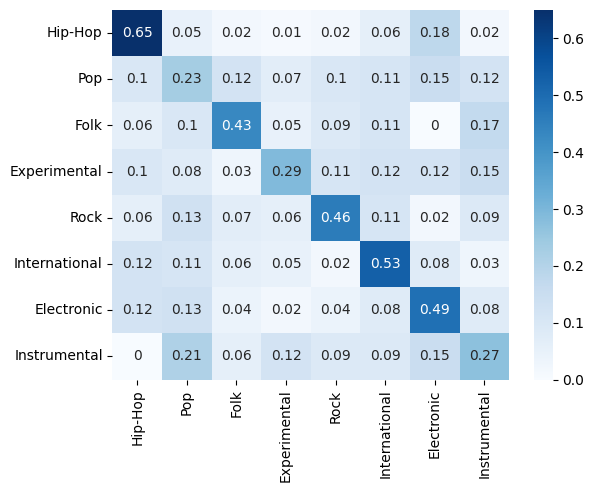

In [ ]:



# Calculate accuracy, precision, recall, and F1 score using sklearn.metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average = 'macro')
recall = recall_score(y_true, y_pred, average = 'macro')
f1 = f1_score(y_true, y_pred, average = 'macro')


conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
labels = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

cm_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)



# Print the results
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

### Get metrics for val dataset ###

In [ ]:
generatingLoader = DataLoader(valset, batch_size=1, shuffle=True)
model.eval()
torch.no_grad()

y_true = []
y_pred =[]
interator =iter(generatingLoader)
for i in range(valset.__len__()):
  data_point, true = next(interator)
  data_point = data_point.float()
  data_point = data_point.to(device)
  y_true.append(true.item())
  pred = model(data_point)
  pred = pred.detach().cpu().numpy()
  max_index = np.argmax(pred)
  y_pred.append(max_index)


y_true = np.array(y_true)
y_pred = np.array(y_pred)

Accuracy: 0.4987012987012987
Precision: 0.49141753125806853
Recall: 0.5052706822126587
F1 Score: 0.4923294353943323


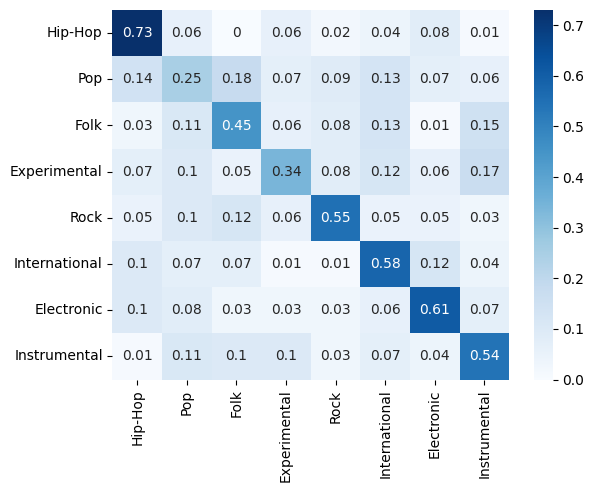

In [ ]:
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average = 'macro')
recall = recall_score(y_true, y_pred, average = 'macro')
f1 = f1_score(y_true, y_pred, average = 'macro')


conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
labels = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

cm_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)



# Print the results
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# TRYING ON DIFFERENT DATA SOURCE #

### Example Data ###

In [13]:
mp3_path_test = 'drive/MyDrive/NeuralNetworksProject/data/test_other'
mp3_files_test = os.listdir(mp3_path_test)
png_path_test = 'drive/MyDrive/NeuralNetworksProject/spec_copy/test_other'
png_files_test = os.listdir(png_path_test)


# create song to label mapping
genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']

In [14]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--workingDir', type=str, 
    default="/content/drive/MyDrive/NeuralNetworksProject")
# Can be game_of_thrones or wonder_land:
parser.add_argument('--outputFile', type=str, default="output") 
parser.add_argument('--maxEpochs', type=int, default=1000)
parser.add_argument('--batchSize', type=int, default=32)
parser.add_argument('--learningRate', type=float, default=.0001)
parser.add_argument('--dropoutRate', type=float, default=0.3)
parser.add_argument('--num_channels', type=float, default=1)
args = parser.parse_args()


checkpointFile = "/content/drive/MyDrive/NeuralNetworksProject/Genre_best_model_1000"
# If using GPU, we need the following line.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Currently using device: ", device)
# Initialize the model and print out its configuration
model = CNN(numChannels = args.num_channels, numClasses = 8, dropout_rate = .3)
model.to(device)
model.load_state_dict(torch.load(f"{checkpointFile}.pth", map_location=torch.device(device)))

Currently using device:  cpu


<All keys matched successfully>

### Choose Audio File To diplay ###

There are 40 tracks


In [15]:
SONG_NUMBER = 5 #instrumental
# SONG_NUMBER = 13 # electric
# SONG_NUMBER = 34 #  hip-hop
# SONG_NUMBER = 4 # folk
# SONG_NUMBER = 24 # experimental
spec_file = png_path_test + '/' + png_files_test[SONG_NUMBER]
audio_file = mp3_path_test + '/' + png_files_test[SONG_NUMBER][:-4] + ".mp3"

### Display Input and lable ###

Genre:
Instrumental


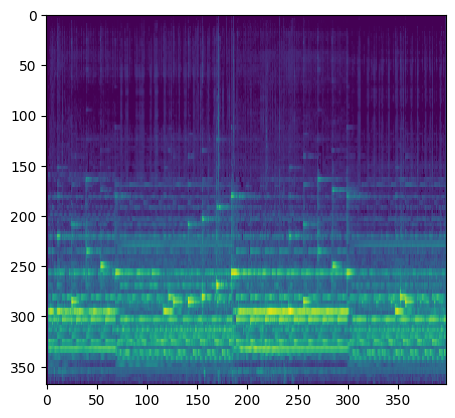

In [16]:
print("Genre:")
print(png_files_test[SONG_NUMBER][:-6])
# Load a PNG file
image = imageio.imread(spec_file)
# Convert the RGBA image to RGB using 
rgb_image = rgba2rgb(image)
# Convert the RGB image to grayscale 
gray_image = rgb2gray(rgb_image)
# take just the graph part of the image
plt.imshow(np.array(gray_image)[59: 427, 79:477])

### Play Audio ##

In [17]:
Audio(audio_file, autoplay=False)

### Accuracy check ###

In [ ]:
class OtherData(torch.utils.data.Dataset):
    def __init__(self,args):
        self.args = args
        self.input_sequence , self.output_sequence = self.loadData()

    def loadData(self):
        inputs = []
        outputs = []

        genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']

        folder_path = self.args.workingDir + "/spec_copy/test_other"
        idx =0
        for file_name in os.listdir(folder_path):
            idx += 1
            if file_name.endswith('.png'):
                # Load a PNG image file as a NumPy array
                image = imageio.imread(os.path.join(folder_path, file_name))
                # Convert the RGBA image to RGB 
                rgb_image = rgba2rgb(image)
                # Convert the RGB image to grayscale 
                gray_image = rgb2gray(rgb_image)
                inputs.append(np.array(gray_image)[59: 427, 79:477])
                outputs.append(genres.index(file_name[:-6]))
            

        return(inputs, outputs)


    def __len__(self):
        return len(self.input_sequence)
    
    def __getitem__(self, index):
        return (
            self.input_sequence[index],
            self.output_sequence[index],
        )
        

In [ ]:
otherset = OtherData(args)
otherLoader = DataLoader(otherset, batch_size=1, shuffle=False)
model.eval()
torch.no_grad()

y_true = []
y_pred =[]
iterator = iter(otherLoader)
for i in range(otherset.__len__()):
  data_point, true = next(iterator)
  data_point = data_point.float()
  data_point = data_point.to(device)
  y_true.append(true.item())
  pred = model(data_point)
  pred = pred.detach().cpu().numpy()
  max_index = np.argmax(pred)
  y_pred.append(max_index)



y_true = np.array(y_true)
y_pred = np.array(y_pred)

Accuracy: 0.425
Precision: 0.4908730158730159
Recall: 0.425
F1 Score: 0.4080357142857143


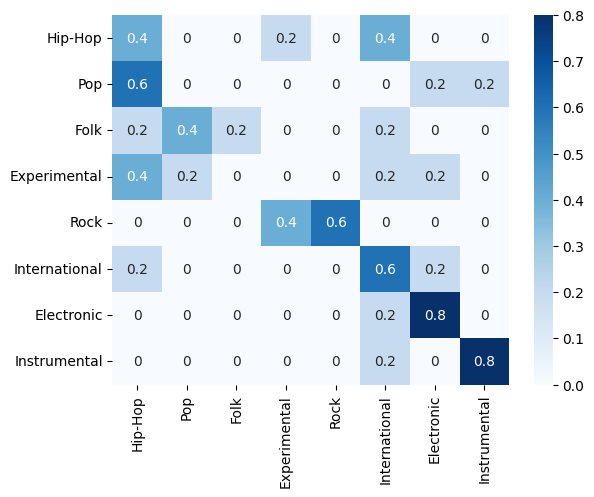

In [ ]:
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average = 'macro')
recall = recall_score(y_true, y_pred, average = 'macro')
f1 = f1_score(y_true, y_pred, average = 'macro')


conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
labels = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

cm_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)



# Print the results
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

## THIS IS WHERE YOU CAN RUN THE NETWORK !!!##

Just choose your file

Can also switch beteen train test and val sets names the same way

train has ~6000 samples

test and val have ~700

just to give an idea of how high you can go with the song number

In [7]:
mp3_path = 'drive/MyDrive/NeuralNetworksProject/data/train'
# mp3_path = 'drive/MyDrive/NeuralNetworksProject/data/test'
# mp3_path = 'drive/MyDrive/NeuralNetworksProject/data/val'
mp3_files = os.listdir(mp3_path)
png_path = 'drive/MyDrive/NeuralNetworksProject/spec_copy/train'
# png_path = 'drive/MyDrive/NeuralNetworksProject/spec_cop  y/test'
# png_path = 'drive/MyDrive/NeuralNetworksProject/spec_copy/val'
png_files = os.listdir(png_path)


# create song to label mapping
genres = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
# build library mapping from song to genre
song_to_genre_show = {}
with open(f"drive/MyDrive/NeuralNetworksProject/output.csv", newline='') as csvfile:
  spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
  for row in spamreader:
    song_to_genre_show[int(row[0])] = genres.index(row[1])


### Choose Audio File To diplay here ###
~ 700 songs

In [8]:
SONG_NUMBER = 40
spec_file = png_path + '/' + png_files[SONG_NUMBER]
audio_file = mp3_path + '/' + png_files[SONG_NUMBER][:-4] + ".mp3"

In [9]:
# load NN and run testing data through it
checkpointFile = "/content/drive/MyDrive/NeuralNetworksProject/Genre_best_model_1000"
# If using GPU, we need the following line.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Currently using device: ", device)
# Initialize the model and print out its configuration
model = CNN(numChannels = args.num_channels, numClasses = 8, dropout_rate = .3)
model.to(device)
model.load_state_dict(torch.load(f"{checkpointFile}.pth", map_location=torch.device(device)))
# testset = TestData(args)
# generatingLoader = DataLoader(testset, batch_size=1, shuffle=True)
model.eval()
torch.no_grad()

Currently using device:  cpu


<ipython-input-10-ef162f2303cc>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(gray_image).float())


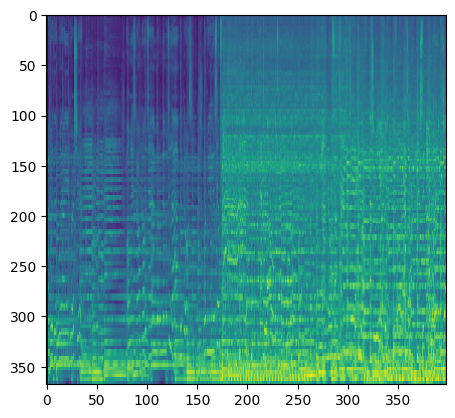

In [10]:

# Load a PNG file
image = imageio.imread(spec_file)
# Convert the RGBA image to RGB using 
rgb_image = rgba2rgb(image)
# Convert the RGB image to grayscale 
gray_image = rgb2gray(rgb_image)
# take just the graph part of the image
plt.imshow(np.array(gray_image)[59: 427, 79:477])
gray_image = torch.tensor(gray_image[59: 427, 79:477]).unsqueeze(0)
pred = model(torch.tensor(gray_image).float())
pred = pred.detach().cpu().numpy()
max_index = np.argmax(pred)


In [11]:
print("True:")
print(genres[song_to_genre_show[int(png_files[SONG_NUMBER][:-4])]])

print("Predicted:")
print(genres[max_index])

True:
Rock
Predicted:
Rock


### Play Audio ##

In [12]:
Audio(audio_file, autoplay=False)

Some expiremental tracks just sound just sound like static but that is just what the music sounds like.


labels = ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']